In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 14.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1
import mediapipe as mp

# Function to extract facial landmarks from images
def extract_facial_landmarks(images):
    marked_images = []
    mp_face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.2)
    mp_drawing = mp.solutions.drawing_utils

    for image in images:
        image_uint8 = tf.image.convert_image_dtype(image, dtype=tf.uint8)
        image_rgb = cv2.cvtColor(image_uint8.numpy(), cv2.COLOR_BGR2RGB)
        results = mp_face_mesh.process(image_rgb)

        if results.multi_face_landmarks:
            # Draw landmarks on the image
            for face_landmarks in results.multi_face_landmarks:
                mp_drawing.draw_landmarks(image_rgb, face_landmarks, mp.solutions.face_mesh.FACEMESH_TESSELATION, landmark_drawing_spec=None, connection_drawing_spec=mp_drawing.DrawingSpec(color=(0,255,0), thickness=1, circle_radius=1))

            marked_images.append(image_rgb)
        else:
            marked_images.append(np.zeros_like(image_rgb, dtype=np.uint8))

    mp_face_mesh.close()
    return marked_images

# Function to load images from a directory
def load_images_from_directory(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Function to create EfficientNetB0
def create_efficientnet_b0(input_shape):
    efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    return efficientnet

# Function to create EfficientNetB1
def create_efficientnet_b1(input_shape):
    efficientnet = EfficientNetB1(weights='imagenet', include_top=False, input_shape=input_shape)
    return efficientnet

# Create two-stream MLP model with EfficientNet as a feature extractor
def create_two_stream_mlp(input_shape, num_classes):
    # Stream 1 for faces
    input_face = layers.Input(shape=input_shape, name='input_face')
    efficientnet_face = create_efficientnet_b0(input_shape)(input_face)
    flatten_face = layers.Flatten()(efficientnet_face)
    dense_face1 = layers.Dense(256, activation='relu')(flatten_face)
    dense_face2 = layers.Dense(128, activation='relu')(dense_face1)

    # Stream 2 for backgrounds
    input_background = layers.Input(shape=input_shape, name='input_background')
    efficientnet_background = create_efficientnet_b1((224, 224, 3))(input_background)
    flatten_background = layers.Flatten()(efficientnet_background)
    dense_background1 = layers.Dense(256, activation='relu')(flatten_background)
    dense_background2 = layers.Dense(128, activation='relu')(dense_background1)

    # Concatenate the two streams
    merged = layers.Concatenate()([dense_face2, dense_background2])

    # Common MLP layers
    common_dense1 = layers.Dense(128, activation='relu')(merged)
    common_dense2 = layers.Dense(64, activation='relu')(common_dense1)

    # Output layer
    output_layer = layers.Dense(num_classes, activation='softmax')(common_dense2)

    model = models.Model(inputs=[input_face, input_background], outputs=output_layer)
    return model

# Hyperparameters
input_shape = (224, 224, 3)
num_classes = 7  # Assuming each class has a directory

train_faces_dir = "/content/drive/MyDrive/caers/modifed/faces/train/"
train_backgrounds_dir = "/content/drive/MyDrive/caers/modifed/backgrounds/train/"

val_faces_dir = "/content/drive/MyDrive/caers/modifed/faces/validation/"
val_backgrounds_dir = "/content/drive/MyDrive/caers/modifed/backgrounds/validation/"

# Load processed face and background images
train_faces, train_face_labels = load_images_from_directory(train_faces_dir)
train_backgrounds, train_background_labels = load_images_from_directory(train_backgrounds_dir)

val_faces, val_face_labels = load_images_from_directory(val_faces_dir)
val_backgrounds, val_background_labels = load_images_from_directory(val_backgrounds_dir)

# Extract facial landmarks
train_face_landmarks = extract_facial_landmarks(train_faces)
val_face_landmarks = extract_facial_landmarks(val_faces)

# Convert landmarks and labels to NumPy arrays
train_face_landmarks_array = np.array(train_face_landmarks, dtype=np.float32)
val_face_landmarks_array = np.array(val_face_landmarks, dtype=np.float32)

# Extract backgrounds from datasets
train_backgrounds_array = np.array(train_backgrounds, dtype=np.float32)
val_backgrounds_array = np.array(val_backgrounds, dtype=np.float32)

model = create_two_stream_mlp(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Convert labels to one-hot encoding
train_face_labels_one_hot = to_categorical(train_face_labels, num_classes=num_classes)
val_face_labels_one_hot = to_categorical(val_face_labels, num_classes=num_classes)

checkpoint_filepath = '/content/drive/MyDrive/caers/model_checkpoints/effnet_landmark_two_stream/best_model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Save the entire model
    monitor='val_accuracy',  # Monitor validation accuracy for saving the best model
    mode='max',  # Save the model when validation accuracy is maximized
    save_best_only=True,  # Save only the best model
    verbose=1  # Display messages
)

# Train the model
model.fit(
    [train_face_landmarks_array, train_backgrounds_array],
    train_face_labels_one_hot,
    epochs=50,
    validation_data=([val_face_landmarks_array, val_backgrounds_array], val_face_labels_one_hot),
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 1.4094 - accuracy: 0.5510
Epoch 1: val_accuracy improved from -inf to 0.63788, saving model to /content/drive/MyDrive/caers/model_checkpoints/effnet_landmark_two_stream/best_model.h5
43/43 [==============================] - 324s 6s/step - loss: 1.4094 - accuracy: 0.5510 - val_loss: 1.4127 - val_accuracy: 0.6379
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 0.4990 - accuracy: 0.8535
Epoch 2: val_accuracy improved from 0.63788 to 0.65152, saving model to /content/drive/MyDrive/caers/model_checkpoints/effnet_landmark_two_stream/best_model.h5
43/43 [==============================] - 275s 6s/step - loss: 0.4990 - accuracy: 0.8535 - val_loss: 1.5463 - val_accuracy: 0.6515
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 0.2799 - accuracy: 0.9147
Epoch 3: val_accuracy improved from 0.65152 to 0.73485, saving model to /content/drive/MyDrive/caers/model_checkpoints/effnet_landmark_two_st

1/1 [==============================] - 0s 100ms/step
660
660
[[0.80392157 0.02597403 0.         0.02777778 0.05882353 0.01030928
  0.02197802]
 [0.10784314 0.94805195 0.01204819 0.05555556 0.00980392 0.02061856
  0.01098901]
 [0.03921569 0.01298701 0.90361446 0.00925926 0.01960784 0.
  0.13186813]
 [0.00980392 0.         0.01204819 0.77777778 0.03921569 0.
  0.02197802]
 [0.01960784 0.01298701 0.         0.0462963  0.78431373 0.05154639
  0.03296703]
 [0.01960784 0.         0.04819277 0.01851852 0.02941176 0.84536082
  0.01098901]
 [0.         0.         0.02409639 0.06481481 0.05882353 0.07216495
  0.76923077]]


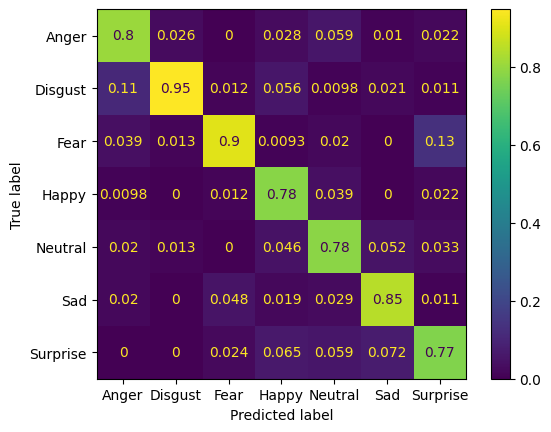

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1
from keras.models import load_model

y_pred = []  # store predicted labels
y_true = []  # store true labels

def create_efficientnet_b0(input_shape):
    efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    return efficientnet

# Function to create EfficientNetB1
def create_efficientnet_b1(input_shape):
    efficientnet = EfficientNetB1(weights='imagenet', include_top=False, input_shape=input_shape)
    return efficientnet

# Create two-stream MLP model with EfficientNet as a feature extractor
def create_two_stream_mlp(input_shape):
    # Stream 1 for faces
    input_face = layers.Input(shape=input_shape, name='input_face')
    efficientnet_face = create_efficientnet_b0(input_shape)(input_face)
    flatten_face = layers.Flatten()(efficientnet_face)
    dense_face1 = layers.Dense(256, activation='relu')(flatten_face)
    dense_face2 = layers.Dense(128, activation='relu')(dense_face1)

    # Stream 2 for backgrounds
    input_background = layers.Input(shape=input_shape, name='input_background')
    efficientnet_background = create_efficientnet_b1((224, 224, 3))(input_background)
    flatten_background = layers.Flatten()(efficientnet_background)
    dense_background1 = layers.Dense(256, activation='relu')(flatten_background)
    dense_background2 = layers.Dense(128, activation='relu')(dense_background1)

    # Concatenate the two streams
    merged = layers.Concatenate()([dense_face2, dense_background2])

    # Common MLP layers
    common_dense1 = layers.Dense(128, activation='relu')(merged)
    common_dense2 = layers.Dense(64, activation='relu')(common_dense1)

    # Output layer
    output_layer = layers.Dense(num_classes, activation='softmax')(common_dense2)

    model = models.Model(inputs=[input_face, input_background], outputs=output_layer)
    return model


# Function to load images from a directory
def load_images_from_directory(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

input_shape = (224, 224, 3)
num_classes = 7  # Assuming each class has a directory


# Create two-stream MLP model
model = create_two_stream_mlp(input_shape)

model.load_weights('/content/drive/MyDrive/caers/model_checkpoints/effnet_landmark_two_stream/best_model.h5')

# iterate over the dataset
for val_face, val_background, label in zip(val_face_landmarks_array, val_backgrounds_array, val_face_labels_one_hot):
    val_face = np.reshape(val_face, (-1, 224, 224, 3))
    val_background = np.reshape(val_background, (-1, 224, 224, 3))

    # append true labels # Use extend instead of append

    # compute predictions
    preds = model.predict([val_face, val_background])

    # append predicted labels
    y_true.extend([np.argmax(label, axis=-1)] * len(val_face))
    y_pred.extend(np.argmax(preds, axis=-1).tolist())  # Use extend instead of append

# convert the true and predicted labels into tensors
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)
print(len(y_true_np))
print(len(y_pred_np))

from sklearn.metrics import confusion_matrix
result = confusion_matrix(y_true_np, y_pred_np, normalize='pred')
print(result)

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

cm_display.plot()
plt.show()